### Imports and setup

In [3]:
import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyreadr
import seaborn as sns
import statsmodels.formula.api as smf
from psmpy import PsmPy
from scipy.spatial.distance import mahalanobis

pd.set_option("display.max_columns", None)

In [4]:
PATH = "../testdata/lalonde.RData"
seed = 1234
num_trees = None

Y = "re78"
treat = "treat"
covar = [
    "age",
    "education",
    "black",
    "hispanic",
    "married",
    "nodegree",
    "re74",
    "re75",
    "u74",
    "u75",
]

raw = pyreadr.read_r(PATH)
# raw.keys()

In [5]:
# Chat GPT translation from R
# ===========================


def standardized_diff(data, treat, covar):
    treated = data[data[treat] == 1]
    control = data[data[treat] == 0]

    std_diff = []
    for var in covar:
        mean_treated = treated[var].mean()
        mean_control = control[var].mean()
        sd_pooled = np.sqrt((treated[var].var() + control[var].var()) / 2)
        std_diff.append((mean_treated - mean_control) / sd_pooled)

    return np.array(std_diff)


def love_plot(data_pre, data_post, treat, covar, threshold=0.1, title="Love Plot"):
    std_diff_pre = standardized_diff(data_pre, treat, covar)
    std_diff_post = standardized_diff(data_post, treat, covar)

    love_data = pd.DataFrame(
        {
            "Variable": np.tile(covar, 2),
            "Std_Diff": np.concatenate([std_diff_pre, std_diff_post]),
            "Matching": ["Pre-Matching"] * len(covar) + ["Post-Matching"] * len(covar),
        }
    )

    plt.figure(figsize=(8, 6))
    sns.scatterplot(data=love_data, x="Variable", y="Std_Diff", hue="Matching", s=100)

    plt.axhline(0, linestyle="--", color="black", linewidth=1)
    plt.axhline(threshold, linestyle="--", color="red", linewidth=1)
    plt.axhline(-threshold, linestyle="--", color="red", linewidth=1)

    plt.title(title)
    plt.xlabel("Covariates")
    plt.ylabel("Standardized Mean Differences")
    plt.xticks(rotation=90)
    plt.gca().invert_yaxis()
    plt.grid(True, which="both", linestyle="--", linewidth=0.5)
    plt.tight_layout()
    plt.show()

___
## LDW-CPS1

In [6]:
data = raw["ldw_cps"].copy().reset_index(drop=True)
data.reset_index(inplace=True, names="row_idx")

In [7]:
data.groupby(treat)["sample"].count()

treat
0.0    15992
1.0      185
Name: sample, dtype: int64

### Covariate balance

In [8]:
data[data[treat] == 0][covar].describe().T.drop(columns=["count"])

,mean,std,min,25%,50%,75%,max
age,33.225238,11.045216,16.0,24.000000,31.000000,42.000000,55.000000
education,12.027514,2.870846,0.0,11.000000,12.000000,13.000000,18.000000
black,0.073537,0.261024,0.0,0.000000,0.000000,0.000000,1.000000
hispanic,0.072036,0.258556,0.0,0.000000,0.000000,0.000000,1.000000
married,0.711731,0.452971,0.0,0.000000,1.000000,1.000000,1.000000
nodegree,0.295835,0.456432,0.0,0.000000,0.000000,1.000000,1.000000
re74,14016.800360,9569.795964,0.0,4403.452393,15123.580078,23584.179688,25862.320312
re75,13650.803522,9270.403408,0.0,4398.823242,14557.110352,22923.736816,25243.550781
u74,0.119622,0.324530,0.0,0.000000,0.000000,0.000000,1.000000
u75,0.109305,0.312031,0.0,0.000000,0.000000,0.000000,1.000000


In [9]:
data[data[treat] == 1][covar].describe().T.drop(columns=["count"])

,mean,std,min,25%,50%,75%,max
age,25.816216,7.155019,17.0,20.0,25.0,29.000000,48.000000
education,10.345946,2.010650,4.0,9.0,11.0,12.000000,16.000000
black,0.843243,0.364558,0.0,1.0,1.0,1.000000,1.000000
hispanic,0.059459,0.237124,0.0,0.0,0.0,0.000000,1.000000
married,0.189189,0.392722,0.0,0.0,0.0,0.000000,1.000000
nodegree,0.708108,0.455867,0.0,0.0,1.0,1.000000,1.000000
re74,2095.573693,4886.620354,0.0,0.0,0.0,1291.468018,35040.070312
re75,1532.055313,3219.250879,0.0,0.0,0.0,1817.284058,25142.240234
u74,0.708108,0.455867,0.0,0.0,1.0,1.000000,1.000000
u75,0.600000,0.491227,0.0,0.0,1.0,1.000000,1.000000


### Positivity check

c:\Users\daygo\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\daygo\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


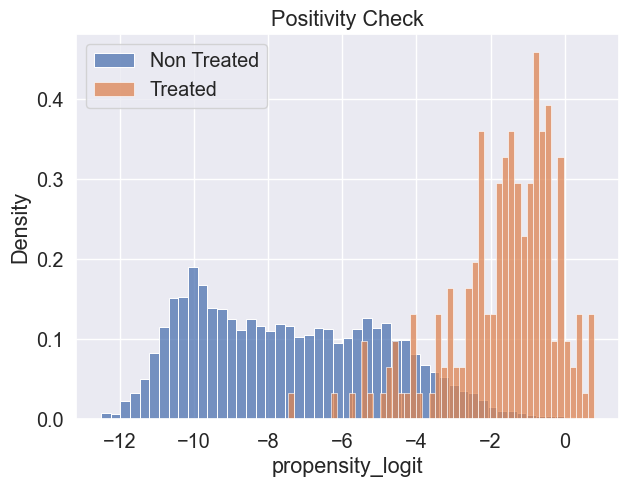

In [10]:
psm = PsmPy(data, treatment=treat, indx="row_idx", exclude=["data_id", Y, "sample"])
psm.logistic_ps(balance=False)

plt.figure(figsize=(7, 5))
sns.histplot(
    psm.predicted_data.query("treat==0")["propensity_logit"],
    kde=False,
    label="Non Treated",
    bins=50,
    stat="density",
)
sns.histplot(
    psm.predicted_data.query("treat==1")["propensity_logit"],
    kde=False,
    label="Treated",
    bins=50,
    stat="density",
)
plt.title("Positivity Check")
plt.legend();

### Mean difference

In [11]:
data.query("treat==1")[Y].mean() - data.query("treat==0")[Y].mean()

-8497.516148132978

### Estimation via linear regression

In [12]:
lr = smf.ols("re78 ~ treat", data=data).fit()

lr.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,1.485e+04,76.143,194.984,0.000,1.47e+04,1.5e+04
treat,-8497.5161,712.021,-11.934,0.000,-9893.156,-7101.877


In [16]:
eqn = "re78 ~ treat + age + education + black + hispanic + married + nodegree + re74 + re74 + u74 + u75"
lr = smf.ols(eqn, data=data).fit()

lr.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,5977.4241,461.135,12.962,0.000,5073.548,6881.300
treat,966.7699,573.398,1.686,0.092,-157.153,2090.693
age,-87.0158,6.206,-14.022,0.000,-99.180,-74.852
education,239.0579,29.635,8.067,0.000,180.970,297.146
black,-902.9544,220.263,-4.099,0.000,-1334.695,-471.214
hispanic,-159.0173,226.232,-0.703,0.482,-602.458,284.423
married,595.4408,147.156,4.046,0.000,306.999,883.883
nodegree,217.8513,184.051,1.184,0.237,-142.909,578.612
re74,0.6267,0.008,74.073,0.000,0.610,0.643
u74,1345.7785,237.846,5.658,0.000,879.573,1811.984


### Assessing overlap


- First, we merge and estimate each unit's propensity of being included in the experiment. We set a threshold to trim data with estimated propensity scores exceeding this value. Merely trimming the nonexperimental controls is inadequate, as the nonexperimental dataset lack partiular profiles of participants of the experiment.

In [17]:
# Data preparation
# ================
ldw_co = raw["ldw_co"].copy()
ldw_co["treat"] = 1

ldw_cps_plus = pd.concat([raw["ldw_cps"], raw["ldw_co"]])

In [18]:
data = ldw_cps_plus.copy().reset_index(drop=True)
data.reset_index(inplace=True, names="row_idx")

psm_ = PsmPy(data, treatment=treat, indx="row_idx", exclude=["data_id", Y, "sample"])
psm_.logistic_ps(balance=False)

tmp = pd.merge(
    data[["row_idx", "sample", Y]], psm_.predicted_data, on=["row_idx"], how="left"
)
tmp.head(3)

,row_idx,sample,re78,age,education,black,hispanic,married,nodegree,re74,re75,u74,u75,propensity_score,propensity_logit,treat
0,0,1.0,9930.045898,37.0,11.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.088154,-2.336380,1
1,1,1.0,3595.894043,22.0,9.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.026862,-3.589811,1
2,2,1.0,24909.449219,30.0,12.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.225451,-1.234177,1


- Second, using the trimmed data and the same set of covariates, we re-estimate propensity scores, this time excluding the experimental controls.

In [19]:
ldw_cps_trim = tmp[(tmp["propensity_score"] < 0.9) & (tmp["sample"].isin([1, 3]))]

In [20]:
# Recalculate PS over trimmed data

psm = PsmPy(ldw_cps_trim, treatment=treat, indx="row_idx", exclude=[Y, "sample"])
psm.logistic_ps(balance=False)
psm.knn_matched(matcher="propensity_score", replacement=False, caliper=None)

tmp = pd.merge(
    data[["row_idx", "sample", Y]], psm.df_matched, on=["row_idx"], how="left"
)

treat_grp = tmp[tmp["treat"] == 1].copy()
untreat_grp = tmp[tmp["treat"] == 0].copy()

treat_grp["matched_ID"] = treat_grp["matched_ID"].astype("int")

In [21]:
aux = pd.merge(
    treat_grp,
    untreat_grp,
    left_on="matched_ID",
    right_on="row_idx",
    how="left",
    suffixes=["_treat", "_untreat"],
)

print(aux.shape)
aux[["propensity_score_treat", "propensity_score_untreat"]].head()

(185, 34)


,propensity_score_treat,propensity_score_untreat
0,0.144040,0.144141
1,0.032093,0.032147
2,0.366537,0.366537
3,0.351343,0.356365
4,0.456421,0.454853


In [22]:
matched_ids = (
    aux.loc[:, "row_idx_treat"].tolist() + aux.loc[:, "row_idx_untreat"].tolist()
)
len(matched_ids)

370

In [23]:
ldw_cps_trim_match = (
    tmp[tmp["row_idx"].isin(matched_ids)].drop(columns=["matched_ID"]).copy()
)

c:\Users\daygo\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\daygo\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


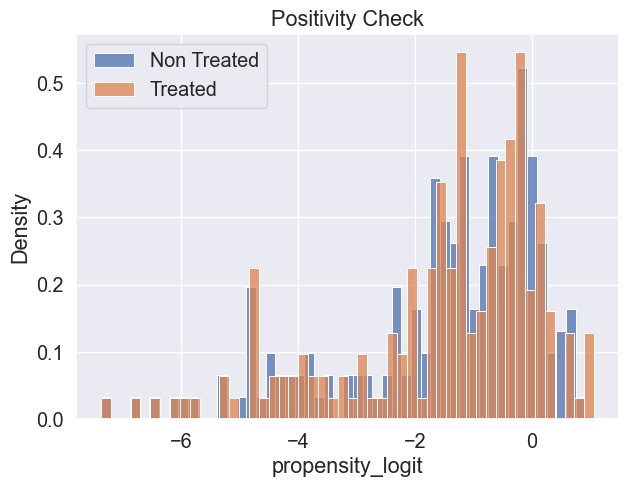

In [24]:
plt.figure(figsize=(7, 5))
sns.histplot(
    ldw_cps_trim_match.query("treat==0")["propensity_logit"],
    kde=False,
    label="Non Treated",
    bins=50,
    stat="density",
)
sns.histplot(
    ldw_cps_trim_match.query("treat==1")["propensity_logit"],
    kde=False,
    label="Treated",
    bins=50,
    stat="density",
)
plt.title("Positivity Check")
plt.legend();

### ATE

In [25]:
(
    ldw_cps_trim_match.query("treat==1")[Y].mean()
    - ldw_cps_trim_match.query("treat==0")[Y].mean()
)

1356.3048915141344

### Covariate balance of matched sample

In [26]:
ldw_cps_trim_match[ldw_cps_trim_match[treat] == 0][covar].describe().T.drop(
    columns=["count"]
)

,mean,std,min,25%,50%,75%,max
age,24.843243,10.425839,16.0,17.0,20.0,29.000000,55.000000
education,10.000000,3.044953,0.0,9.0,11.0,12.000000,16.000000
black,0.837838,0.369600,0.0,1.0,1.0,1.000000,1.000000
hispanic,0.027027,0.162602,0.0,0.0,0.0,0.000000,1.000000
married,0.167568,0.374495,0.0,0.0,0.0,0.000000,1.000000
nodegree,0.605405,0.490090,0.0,0.0,1.0,1.000000,1.000000
re74,2197.746656,4330.591579,0.0,0.0,0.0,2355.039062,24394.830078
re75,1713.977376,3440.809534,0.0,0.0,0.0,1554.000000,17292.730469
u74,0.529730,0.500470,0.0,0.0,1.0,1.000000,1.000000
u75,0.513514,0.501174,0.0,0.0,1.0,1.000000,1.000000


In [27]:
ldw_cps_trim_match[ldw_cps_trim_match[treat] == 1][covar].describe().T.drop(
    columns=["count"]
)

,mean,std,min,25%,50%,75%,max
age,25.816216,7.155019,17.0,20.0,25.0,29.000000,48.000000
education,10.345946,2.010650,4.0,9.0,11.0,12.000000,16.000000
black,0.843243,0.364558,0.0,1.0,1.0,1.000000,1.000000
hispanic,0.059459,0.237124,0.0,0.0,0.0,0.000000,1.000000
married,0.189189,0.392722,0.0,0.0,0.0,0.000000,1.000000
nodegree,0.708108,0.455867,0.0,0.0,1.0,1.000000,1.000000
re74,2095.573693,4886.620354,0.0,0.0,0.0,1291.468018,35040.070312
re75,1532.055313,3219.250879,0.0,0.0,0.0,1817.284058,25142.240234
u74,0.708108,0.455867,0.0,0.0,1.0,1.000000,1.000000
u75,0.600000,0.491227,0.0,0.0,1.0,1.000000,1.000000


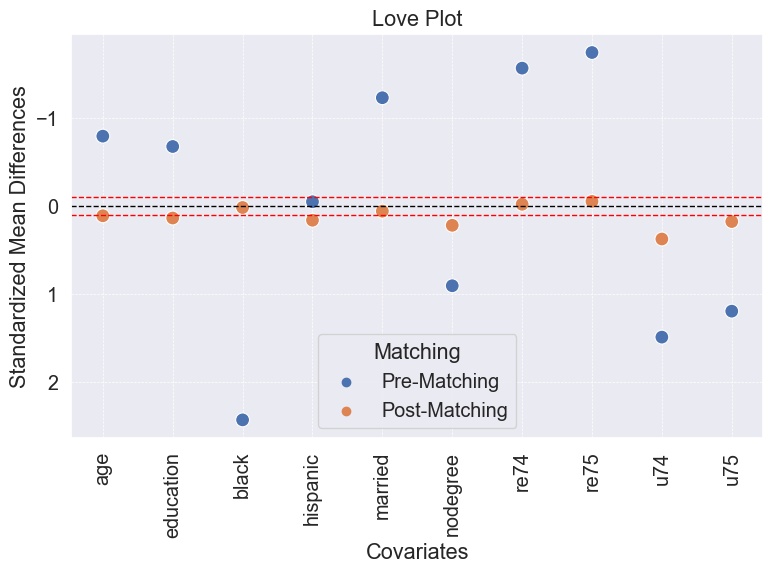

In [28]:
love_plot(raw["ldw_cps"], ldw_cps_trim_match, treat, covar)

### Appendix: Matching with Mahalanobis distance

In [30]:
X = raw["ldw_cps"].copy()

V = np.cov(X[covar].values.T)
VI = np.linalg.inv(V)

treated_grp = X[X[treat] == 1].reset_index(drop=True)
untreated_grp = X[X[treat] == 0].reset_index(drop=True)

treated_grp.reset_index(inplace=True, names="row_idx")
untreated_grp.reset_index(inplace=True, names="row_idx")

treated_grp.shape, untreated_grp.shape

((185, 14), (15992, 14))

In [32]:
%%time
results = {}

for i, row_treat in treated_grp.iterrows():
    min_dist = []
    for j, row_untreat in untreated_grp.iterrows():
        dist = mahalanobis(row_treat[covar], row_untreat[covar], VI)
        min_dist.append(dist)
    # print(f"Match for treated {i} reached at index {np.argmin(min_dist)}")
    results.update({i: np.argmin(min_dist)})

# Wall time: 23min 28s

Match for treated 0 reached at index 1431
Match for treated 1 reached at index 7597
Match for treated 2 reached at index 1658
Match for treated 3 reached at index 5306
Match for treated 4 reached at index 9472
Match for treated 5 reached at index 2584
Match for treated 6 reached at index 1796
Match for treated 7 reached at index 5632
Match for treated 8 reached at index 5326
Match for treated 9 reached at index 680
Match for treated 10 reached at index 2584
Match for treated 11 reached at index 5607
Match for treated 12 reached at index 3946
Match for treated 13 reached at index 12463
Match for treated 14 reached at index 3946
Match for treated 15 reached at index 13964
Match for treated 16 reached at index 1135
Match for treated 17 reached at index 11077
Match for treated 18 reached at index 10620
Match for treated 19 reached at index 1796
Match for treated 20 reached at index 5306
Match for treated 21 reached at index 13956
Match for treated 22 reached at index 10099
Match for treate

In [35]:
joblib.dump(results, "mahalanobis-match.pkl")

['mahalanobis-match.pkl']

In [39]:
treated_grp["match_ID"] = treated_grp["row_idx"].map(results)

In [51]:
mahalanobis_match_treated = list(results.keys())
mahalanobis_match_control = list(results.values())

mhlnb_match_t = treated_grp[untreated_grp["row_idx"].isin(mahalanobis_match_treated)]
mhlnb_match_c = untreated_grp[untreated_grp["row_idx"].isin(mahalanobis_match_control)]

mhlnb_match = pd.concat([mhlnb_match_t, mhlnb_match_c])

**Covariate balance**

In [59]:
mhlnb_match_t[covar].describe().T.drop(columns=["count"])

C:\Users\daygo\AppData\Local\Temp\ipykernel_14532\1126656064.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  mhlnb_match_t = treated_grp[untreated_grp["row_idx"].isin(mahalanobis_match_treated)]


,mean,std,min,25%,50%,75%,max
age,25.816216,7.155019,17.0,20.0,25.0,29.000000,48.000000
education,10.345946,2.010650,4.0,9.0,11.0,12.000000,16.000000
black,0.843243,0.364558,0.0,1.0,1.0,1.000000,1.000000
hispanic,0.059459,0.237124,0.0,0.0,0.0,0.000000,1.000000
married,0.189189,0.392722,0.0,0.0,0.0,0.000000,1.000000
nodegree,0.708108,0.455867,0.0,0.0,1.0,1.000000,1.000000
re74,2095.573693,4886.620354,0.0,0.0,0.0,1291.468018,35040.070312
re75,1532.055313,3219.250879,0.0,0.0,0.0,1817.284058,25142.240234
u74,0.708108,0.455867,0.0,0.0,1.0,1.000000,1.000000
u75,0.600000,0.491227,0.0,0.0,1.0,1.000000,1.000000


In [60]:
mhlnb_match_c[covar].describe().T.drop(columns=["count"])

,mean,std,min,25%,50%,75%,max
age,25.852174,9.039139,16.0,19.0,23.000000,31.000000,51.000000
education,10.478261,2.031972,3.0,9.0,11.000000,12.000000,15.000000
black,0.756522,0.431060,0.0,1.0,1.000000,1.000000,1.000000
hispanic,0.086957,0.283004,0.0,0.0,0.000000,0.000000,1.000000
married,0.234783,0.425718,0.0,0.0,0.000000,0.000000,1.000000
nodegree,0.652174,0.478365,0.0,0.0,1.000000,1.000000,1.000000
re74,3162.563184,5203.973352,0.0,0.0,0.000000,4867.798340,25113.880859
re75,2318.389945,3724.310411,0.0,0.0,449.371002,3378.338501,20488.449219
u74,0.556522,0.498969,0.0,0.0,1.000000,1.000000,1.000000
u75,0.443478,0.498969,0.0,0.0,0.000000,1.000000,1.000000


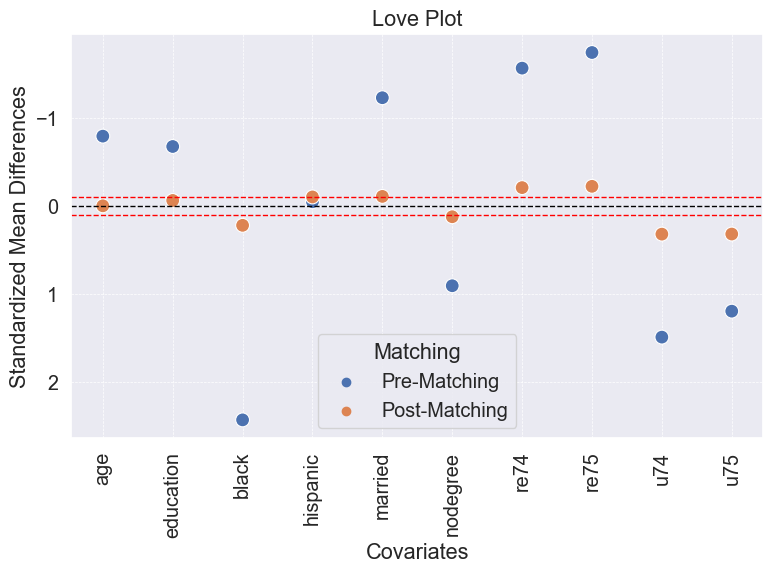

In [64]:
love_plot(raw["ldw_cps"], mhlnb_match, treat, covar)

**ATE**

In [65]:
mhlnb_match.query("treat==1")[Y].mean() - mhlnb_match.query("treat==0")[Y].mean()

1120.8184196346656